## Raindrop Removal
This notebook is for implementing Raindrop Removing Network from the paper [Adherent Raindrop Removal with Self-Supervised Attention Maps andSpatio-Temporal Generative Adversarial Networks](http://openaccess.thecvf.com/content_ICCVW_2019/papers/ADW/Alletto_Adherent_Raindrop_Removal_with_Self-Supervised_Attention_Maps_and_Spatio-Temporal_Generative_ICCVW_2019_paper.pdf) with [Tensorflow](https://www.tensorflow.org/).

[Raindrop Dataset](https://github.com/rui1996/DeRaindrop) dataset From Qian's github, which is 420x720 size, will be used.

Reference :[machrisaa's github](https://github.com/machrisaa/tensorflow-vgg)(vgg16 network implementation)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

## Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from sklearn.utils import shuffle
import cv2
import glob
import datetime
from os import listdir
from Util_network.vgg16 import *

/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mmc-server1/.local/lib/python3.5/site-packages/tensorflow/python/frame

## Parameters

In [3]:
algorithm = 'Raindrop Removal'

num_epoch  = 100

learning_rate=1e-4

imgx_size=480
imgy_size=720

batch_size = 1

load_model = False
train_model = True

save_path = "./saved_models/Raindrop_removal"

## Import Raindrop Dataset

Rainy_image: 861, Clean_image : 861


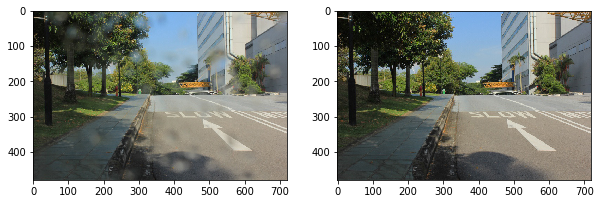

In [4]:
r_image=glob.glob('./../dataset/Raindrop/train/rainy/*.png')
c_image=glob.glob('./../dataset/Raindrop/train/clean/*.png')

r_image.sort()
c_image.sort()

f, im=plt.subplots(1,2, figsize=(10,10))

im[0].imshow(cv2.cvtColor(cv2.imread(r_image[300]),cv2.COLOR_BGR2RGB))
im[1].imshow(cv2.cvtColor(cv2.imread(c_image[300]),cv2.COLOR_BGR2RGB))
print('Rainy_image: {}, Clean_image : {}'.format(len(r_image), len(c_image)))


## Network

In [5]:
def ResNet(x, network_name):
    
    h = tf.layers.conv2d(x, filters=128, kernel_size=3, strides=1, padding='SAME',
                         name=network_name+'_R1')
    h = tf.contrib.layers.instance_norm(h)
    h = tf.nn.relu(h)
    
    h = tf.layers.conv2d(x, filters=128, kernel_size=3, strides=1, padding='SAME',
                         name=network_name+'_R2')
    h = tf.contrib.layers.instance_norm(h)
    h = x + h 
    h = tf.nn.relu(h)
    
    return h

def Estimator(r_img):
    with tf.variable_scope('Estimator', reuse=tf.AUTO_REUSE):  
    
        e1=tf.layers.conv2d(r_img, filters=128, kernel_size=3, strides=2, 
                            padding='SAME')
        e1 = tf.contrib.layers.instance_norm(e1)
        e1 = tf.nn.relu(e1)

        r=ResNet(e1, 'estimator')

        d1 = tf.layers.conv2d_transpose(r, filters=128, kernel_size=3, strides=2,
                                        padding='SAME')
        d1 = tf.contrib.layers.instance_norm(d1)
        d1 = tf.nn.relu(d1)


        d2 = tf.layers.conv2d_transpose(d1, filters=3, 
                    activation=tf.tanh , kernel_size=3, strides=1, padding='SAME')
    
    return d2


def Removal(r_img):
    with tf.variable_scope('Removal', reuse=tf.AUTO_REUSE):   
    
        e1=tf.layers.conv2d(r_img, filters=128, kernel_size=2, strides=2, padding='SAME')
        e1 = tf.contrib.layers.instance_norm(e1)
        e1 = tf.nn.relu(e1)

        r=ResNet(e1, 'removal')

        d1 = tf.layers.conv2d_transpose(r, filters=128, kernel_size=3, strides=2, 
                                        padding='SAME')
        d1 = tf.contrib.layers.instance_norm(d1)
        d1 = tf.nn.relu(d1)
        
        d2 = tf.layers.conv2d_transpose(d1, filters=64, kernel_size=3, strides=1, 
                                        padding='SAME')
        d2 = tf.contrib.layers.instance_norm(d2)
        d2 = tf.nn.relu(d2)
        
        d3 = tf.layers.conv2d_transpose(d2, filters=3,activation=tf.tanh, 
                                        kernel_size=3, strides=1, padding='SAME')
    
    return d3
    
def discriminator(img):
    with tf.variable_scope('dis', reuse=tf.AUTO_REUSE):
        
        ds1=tf.layers.conv2d(img, filters=32, kernel_size=3, strides=2,
                             padding='same')
        ds1 = tf.contrib.layers.instance_norm(ds1)
        ds1=tf.nn.leaky_relu(ds1)
        
        ds2=tf.layers.conv2d(ds1, filters=64, kernel_size=3, strides=2,
                             padding='same')
        ds2 = tf.contrib.layers.instance_norm(ds2)
        ds2=tf.nn.leaky_relu(ds2)
        
        ds3=tf.layers.conv2d(ds2, filters=128, kernel_size=3, strides=2,
                             padding='same')
        ds3 = tf.contrib.layers.instance_norm(ds3)
        ds3=tf.nn.leaky_relu(ds3)
        
        ds4=tf.layers.conv2d(ds3, filters=256, kernel_size=3, strides=2,
                             padding='same')
        ds4=tf.contrib.layers.instance_norm(ds3)
        ds4=tf.nn.leaky_relu(ds3)
        
        ds5=tf.layers.conv2d(ds4, filters=512, kernel_size=3, strides=2,
                             padding='same')
        ds5=tf.contrib.layers.instance_norm(ds5)
        ds5=tf.nn.leaky_relu(ds5)
        
        output = tf.layers.conv2d(ds5, filters=1, kernel_size=3, strides=1,
                                  padding='SAME')
        

        return output

## Build Graph

In [6]:
tf.reset_default_graph()

vgg1=Vgg16('./trained_models/vgg16.npy')
vgg2=Vgg16('./trained_models/vgg16.npy')

r_img=tf.placeholder(tf.float32, shape=[None, imgx_size, imgy_size, 3])
c_img=tf.placeholder(tf.float32, shape=[None, imgx_size, imgy_size, 3])

r_norm=(r_img-255.0/2)/(255.0/2)
c_norm=(c_img-255.0/2)/(255.0/2)

ad_map=Estimator(r_norm)
r_img_est=(c_norm+ad_map)
r_img_est=tf.clip_by_value(r_img_est,-1,1)

d_r=discriminator(r_norm)
d_r_est=discriminator(r_img_est)

input_=(ad_map-tf.reduce_mean(ad_map))*3

r_input=tf.concat([r_norm, input_],3)
c_img_est=Removal(r_input)

c_vgg_est=tf.image.resize_images(c_img_est, size=[224,224])
c_vgg=tf.image.resize_images(c_norm, size=[224,224])

d_c=discriminator(c_norm)
d_c_est=discriminator(c_img_est)

vgg1.build(c_vgg)

t_feat1_2=vgg1.conv1_2
t_feat2_2=vgg1.conv2_2
t_feat3_3=vgg1.conv3_3
t_feat4_3=vgg1.conv4_3

vgg2.build(c_vgg_est)

e_feat1_2=vgg2.conv1_2
e_feat2_2=vgg2.conv2_2
e_feat3_3=vgg2.conv3_3
e_feat4_3=vgg2.conv4_3

E_loss=tf.reduce_mean(tf.square((r_norm-c_norm)- ad_map))
E_adv_loss=tf.reduce_mean(tf.square(d_r-1)) + tf.reduce_mean(tf.square(d_r_est))

vgg_loss=per_loss(t_feat1_2,e_feat1_2)+per_loss(t_feat2_2,e_feat2_2)
    +per_loss(t_feat3_3, e_feat3_3)+per_loss(t_feat1_2,e_feat1_2)+per_loss(t_feat4_3,e_feat4_3)

R_adv_loss=tf.reduce_mean(tf.square(d_c-1)) + tf.reduce_mean(tf.square(d_c_est))

loss= 10*E_loss + 10*vgg_loss+E_adv_loss+R_adv_loss

trainable_variables = tf.trainable_variables()
t_vars = [var for var in trainable_variables if ('Removal' in var.name) 
          or ('Estimator' in var.name) or ('dis' in var.name)]

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss, var_list=t_vars)

npy file loaded
npy file loaded
build model started
build model started


## Initialization

In [7]:
config = tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=1))
sess = tf.Session(config=config)
Saver=tf.train.Saver()
    
init=tf.global_variables_initializer()
sess.run(init)

## Save & Load Model

In [8]:
Saver = tf.train.Saver()

if load_model == True:
    Saver.restore(sess, load_path)

## Train Raindrop Estimator & Removal

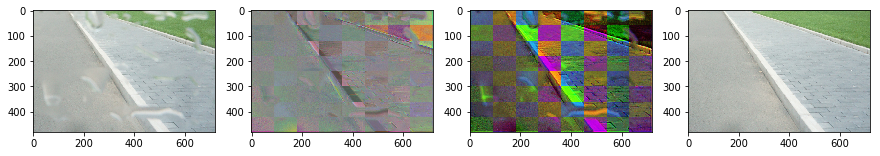

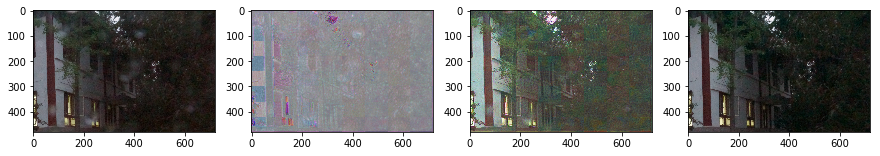

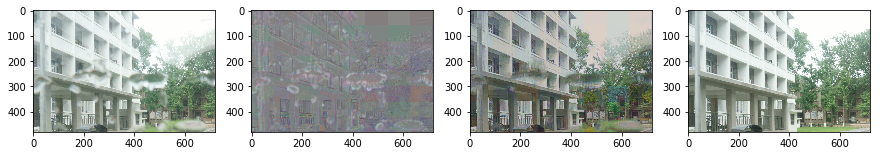

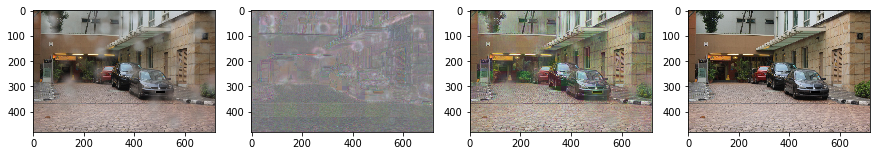

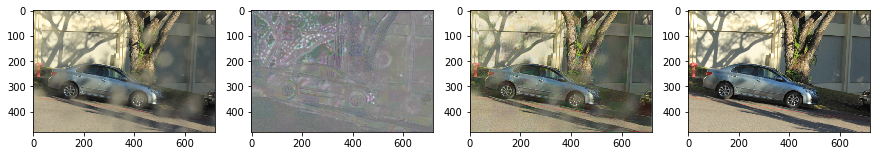

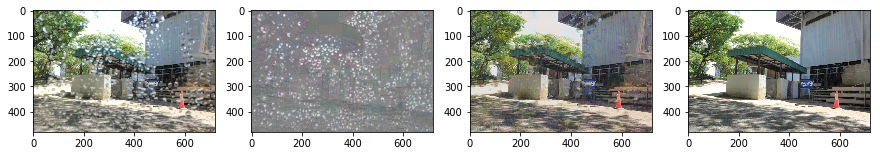

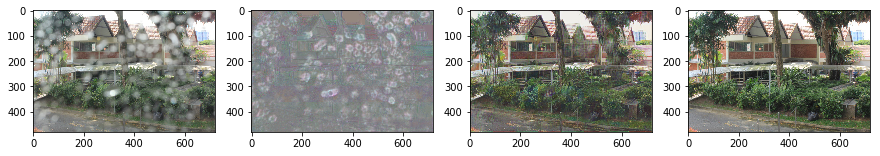

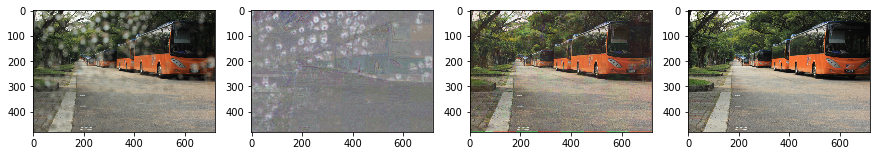

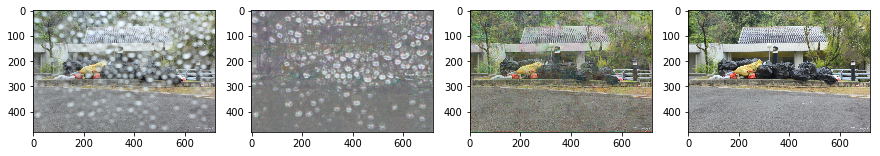

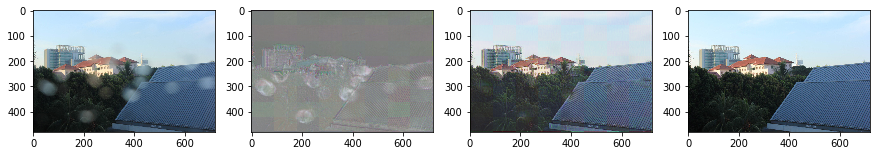

Network Trained5598141696755


In [9]:
if train_model:
    
    len_data=len(r_image)


    for i in range(num_epoch):

        rimage, cimage = shuffle(r_image, c_image)
        
        batch_count = 0
               

        for j in range(0, len_data, batch_size): 
            if j + batch_size < len_data:
                data_x_batch = np.zeros([batch_size, imgx_size, imgy_size, 3])
                data_y_batch = np.zeros([batch_size, imgx_size, imgy_size, 3])

                for k in range(batch_size):
                    img_temp_x = cv2.imread(rimage[j + k])
                    data_x_batch[k,:,:,:] = img_temp_x[0:imgx_size,0:imgy_size]

                    img_temp_y = cv2.imread(cimage[j + k])
                    data_y_batch[k,:,:,:] = img_temp_y[0:imgx_size,0:imgy_size]
                
            
            sess.run(optimizer, feed_dict = {r_img: data_x_batch, c_img:data_y_batch})          
            
            batch_count += 1
            print ("Batch: {}".format(j/len_data), end="\r")
        
        
        if (i%10)==0:
            s=np.random.randint(len_data)

            r= cv2.imread(rimage[s])
            test_x1=r[0:imgx_size,0:imgy_size]

            c = cv2.imread(cimage[s])
            test_x2=c[0:imgx_size,0:imgy_size]

            ad_map_, c_e= sess.run([ad_map,c_img_est], 
                                   feed_dict = {r_img:[test_x1], c_img: [test_x2]})

            ad_map_ = (ad_map_ + 1.0)/2
            c_e = (c_e+1.0)/2

            f, ax=plt.subplots(1,4, figsize=(15,15))

            ax[0].imshow(cv2.cvtColor(test_x1,cv2.COLOR_BGR2RGB))
            ax[1].imshow(cv2.cvtColor(ad_map_[0], cv2.COLOR_BGR2RGB))
            ax[2].imshow(cv2.cvtColor(c_e[0], cv2.COLOR_BGR2RGB))
            ax[3].imshow(cv2.cvtColor(test_x2, cv2.COLOR_BGR2RGB))

            plt.show()
            
    print("Network Trained")

## Test(Test Set A)

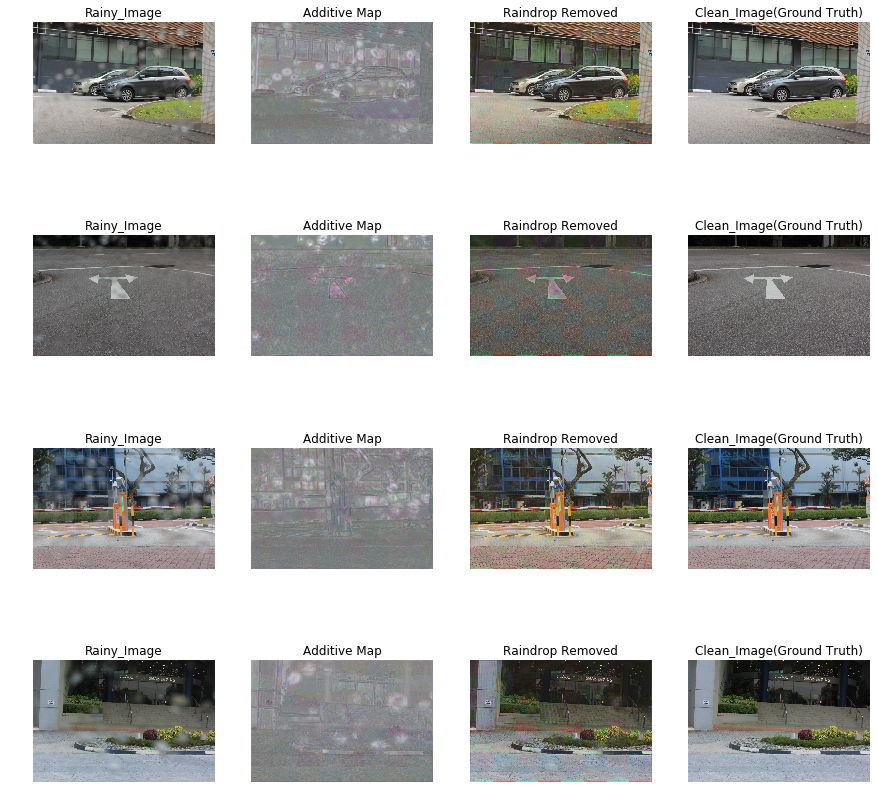

In [27]:
r_test=glob.glob('./../dataset/Raindrop/test_a/test_a/data/*.png')
c_test=glob.glob('./../dataset/Raindrop/test_a/test_a/gt/*.png')

r_test.sort()
c_test.sort()

f, ax =plt.subplots(4,4, figsize=(15,15))

test_len=len(r_test)

for i in range(4):
    s=np.random.randint(test_len)

    r= cv2.imread(r_test[s])
    test_x1=r[0:imgx_size,0:imgy_size]

    c = cv2.imread(c_test[s])
    test_x2=c[0:imgx_size,0:imgy_size]

    ad_map_, c_e= sess.run([ad_map, c_img_est], feed_dict = {r_img:[test_x1]})

    ad_map_ = (ad_map_ + 1.0)/2
    c_e = (c_e+1.0)/2


    ax[i,0].imshow(cv2.cvtColor(test_x1, cv2.COLOR_BGR2RGB))
    ax[i,0].axis('off')
    ax[i,0].set_title('Rainy_Image')
    
    ax[i,1].imshow(cv2.cvtColor(ad_map_[0], cv2.COLOR_BGR2RGB))
    ax[i,1].axis('off')
    ax[i,1].set_title('Additive Map')
    
    ax[i,2].imshow(cv2.cvtColor(c_e[0], cv2.COLOR_BGR2RGB))
    ax[i,2].axis('off')
    ax[i,2].set_title('Raindrop Removed')
    
    ax[i,3].imshow(cv2.cvtColor(test_x2, cv2.COLOR_BGR2RGB))
    ax[i,3].axis('off')
    ax[i,3].set_title('Clean_Image(Ground Truth)')

## Test(Test Set B)

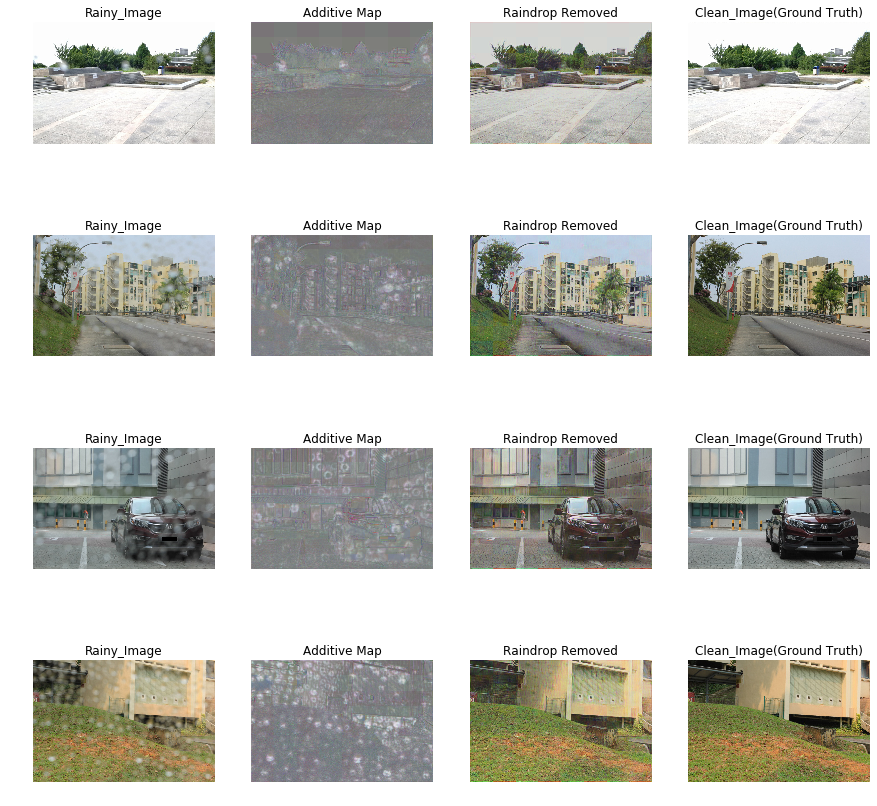

In [11]:
r_test=glob.glob('./../dataset/Raindrop/test_b/test_b/data/*.jpg')
c_test=glob.glob('./../dataset/Raindrop/test_b/test_b/gt/*.jpg')

r_test.sort()
c_test.sort()

f, ax =plt.subplots(4,4, figsize=(15,15))

test_len=len(r_test)


for i in range(4):
    s=np.random.randint(test_len)

    r= cv2.imread(r_test[s])
    test_x1=r[0:imgx_size,0:imgy_size]

    c = cv2.imread(c_test[s])
    test_x2=c[0:imgx_size,0:imgy_size]

    ad_map_, c_e= sess.run([ad_map, c_img_est], feed_dict = {r_img:[test_x1]})

    ad_map_ = (ad_map_ + 1.0)/2
    c_e = (c_e+1.0)/2

    ax[i,0].imshow(cv2.cvtColor(test_x1, cv2.COLOR_BGR2RGB))
    ax[i,0].axis('off')
    ax[i,0].set_title('Rainy_Image')
    
    ax[i,1].imshow(cv2.cvtColor(ad_map_[0], cv2.COLOR_BGR2RGB))
    ax[i,1].axis('off')
    ax[i,1].set_title('Additive Map')
    
    ax[i,2].imshow(cv2.cvtColor(c_e[0], cv2.COLOR_BGR2RGB))
    ax[i,2].axis('off')
    ax[i,2].set_title('Raindrop Removed')
    
    ax[i,3].imshow(cv2.cvtColor(test_x2, cv2.COLOR_BGR2RGB))
    ax[i,3].axis('off')
    ax[i,3].set_title('Clean_Image(Ground Truth)')